In [1]:
import sys
import os
import pickle

library_path = os.path.join('..', '..', 'UCB-USACE-LSTMs')
sys.path.insert(0, library_path)

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation.metrics import *
from neuralhydrology.nh_run import start_run, eval_run, finetune
from neuralhydrology.utils.nh_results_ensemble import create_results_ensemble
from neuralhydrology.UCB_training.UCB_train import UCB_trainer
from neuralhydrology.evaluation.metrics import calculate_all_metrics

In [2]:
print("Current Working Directory:", os.getcwd())
print("Train Basin File Exists:", os.path.exists("calpella"))

Current Working Directory: /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all
Train Basin File Exists: True


In [5]:
path_to_csv = Path("/Users/mia/research/russian_river_data_folder/")
path_to_yaml = Path("calpella_gage.yaml")
params = {
    "epochs":3
}
lstmNoPhysics = UCB_trainer(path_to_csv, yaml_path= path_to_yaml, hyperparams= params)

In [6]:
lstmNoPhysics.train()

2024-11-28 09:32:22,765: Logging to /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_2811_093222/output.log initialized.
2024-11-28 09:32:22,782: ### Folder structure created at /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_2811_093222
2024-11-28 09:32:22,789: ### Run configurations for testing_run
2024-11-28 09:32:22,791: experiment_name: testing_run
2024-11-28 09:32:22,795: train_basin_file: calpella
2024-11-28 09:32:22,800: validation_basin_file: calpella
2024-11-28 09:32:22,807: test_basin_file: calpella
2024-11-28 09:32:22,809: train_start_date: 1994-10-01 00:00:00
2024-11-28 09:32:22,811: train_end_date: 2002-09-30 00:00:00
2024-11-28 09:32:22,813: validation_start_date: 2002-10-01 00:00:00
2024-11-28 09:32:22,821: validation_end_date: 2005-09-30 00:00:00
2024-11-28 09:32:22,828: test_start_date: 2005-10-01 00:00:00
2024-11-28 09:32:22,831: test_end_date: 2009-09-30 00:00:00
2024-11-28 09:32:22,839: device: cpu


Using basin: Calpella
Using target variable: NR CALPELLA FLOW COE CPL


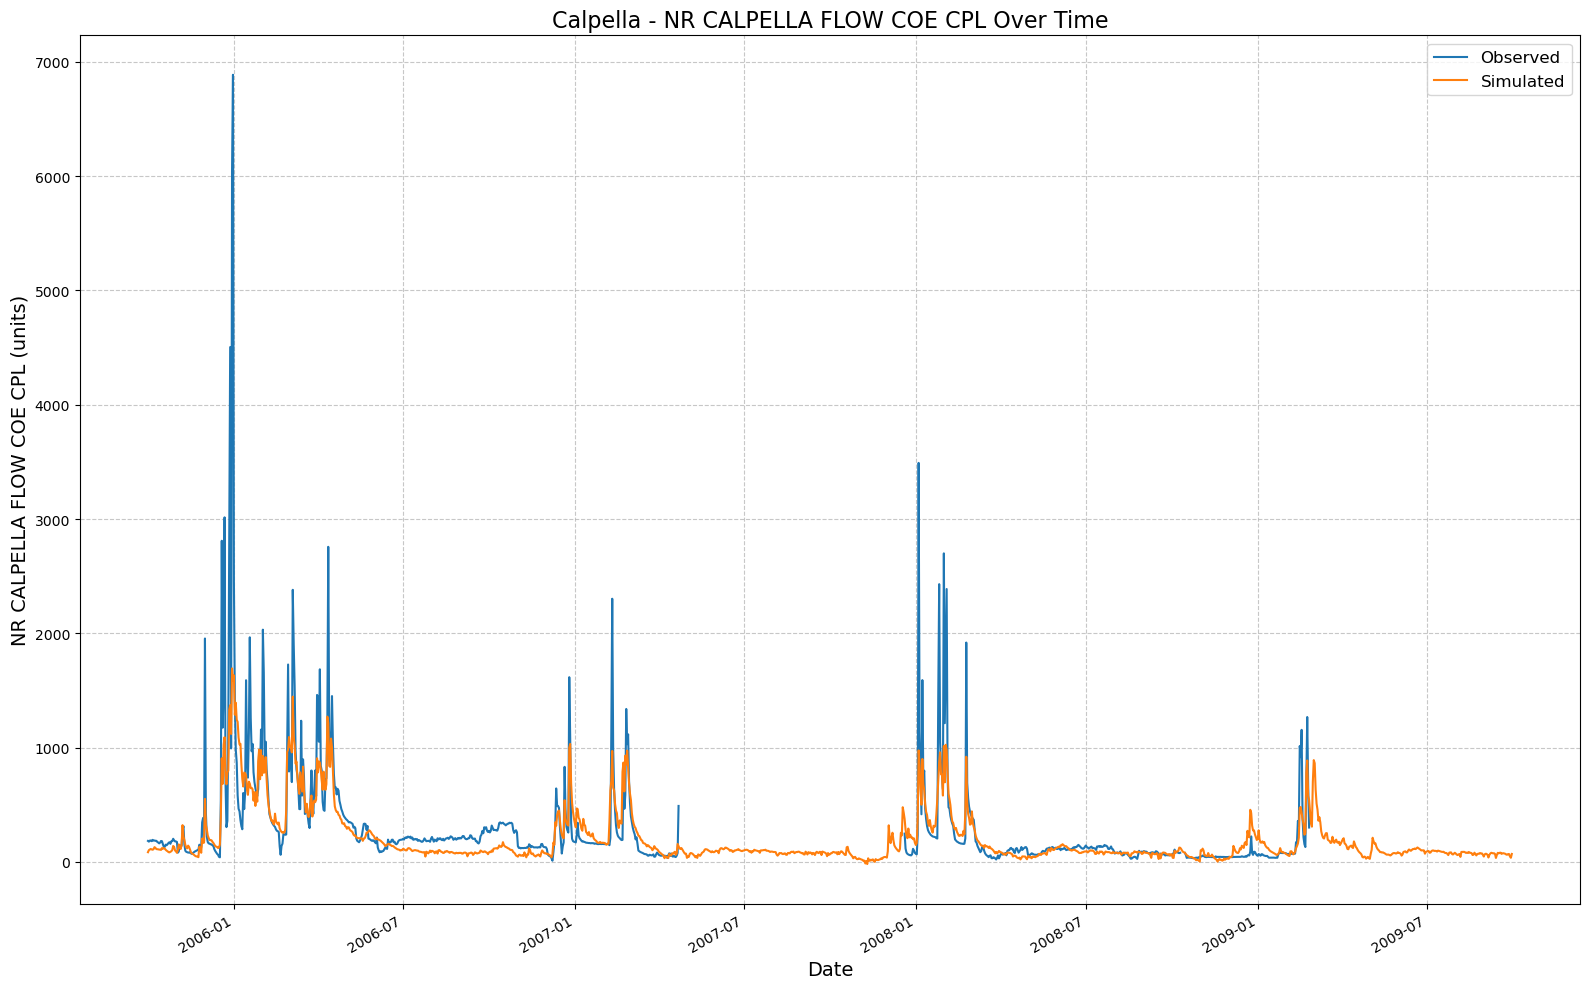

[INFO] CSV output saved at: /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_2811_093222/results_output.csv


{'NSE': 0.5516931116580963,
 'MSE': 114174.6875,
 'RMSE': 337.8974511593717,
 'KGE': 0.46235029974727226,
 'Alpha-NSE': 0.5381689713369204,
 'Beta-KGE': 0.8195807933807373,
 'Beta-NSE': -0.10598758913464822,
 'Pearson-r': 0.7920860489800516,
 'FHV': -56.769949197769165,
 'FMS': 10.347533293529446,
 'FLV': -982.6447693874958,
 'Peak-Timing': 0.75,
 'Peak-MAPE': 54.620704650878906}

In [7]:
lstmNoPhysics.results()

In [3]:
path_to_csv = Path("/Users/mia/research/russian_river_data_folder/")
path_to_yaml = Path("calpella_gage.yaml")
path_to_physics_data = Path("/Users/mia/research/russian_river_data_folder/calpella.csv")
params = {
    "epochs":4
}
features_with_physics = [
    "EF RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "EF RUSSIAN 20 PRECIP-INC SCREENED",
    "POTTER VALLEY CA FLOW USGS_ADJUSTED",
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    "UKIAH CA FLOW USGS-MERGED",
    'Capella Gage FLOW Calpella',
    'EF Russian 20 ET-POTENTIAL Calpella',
    'EF Russian 20 FLOW Calpella',
    'EF Russian 20 FLOW-BASE Calpella',
    'EF Russian 20 INFILTRATION Calpella',
    'EF Russian 20 PERC-SOIL Calpella',
    'EF Russian 20 SATURATION FRACTION Calpella'
]
lstmPhysics = UCB_trainer(path_to_csv, yaml_path= path_to_yaml, hyperparams= params, input_features= features_with_physics, physics_informed=True, physics_data_file=path_to_physics_data)

In [4]:
lstmPhysics.train()

2024-11-28 09:31:10,960: Logging to /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_2811_093110/output.log initialized.
2024-11-28 09:31:10,982: ### Folder structure created at /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_2811_093110
2024-11-28 09:31:10,985: ### Run configurations for testing_run
2024-11-28 09:31:10,995: experiment_name: testing_run
2024-11-28 09:31:11,013: train_basin_file: calpella
2024-11-28 09:31:11,031: validation_basin_file: calpella
2024-11-28 09:31:11,040: test_basin_file: calpella
2024-11-28 09:31:11,042: train_start_date: 1994-10-01 00:00:00
2024-11-28 09:31:11,046: train_end_date: 2002-09-30 00:00:00
2024-11-28 09:31:11,050: validation_start_date: 2002-10-01 00:00:00
2024-11-28 09:31:11,055: validation_end_date: 2005-09-30 00:00:00
2024-11-28 09:31:11,059: test_start_date: 2005-10-01 00:00:00
2024-11-28 09:31:11,061: test_end_date: 2009-09-30 00:00:00
2024-11-28 09:31:11,068: device: cpu


Using basin: Calpella
Using target variable: NR CALPELLA FLOW COE CPL


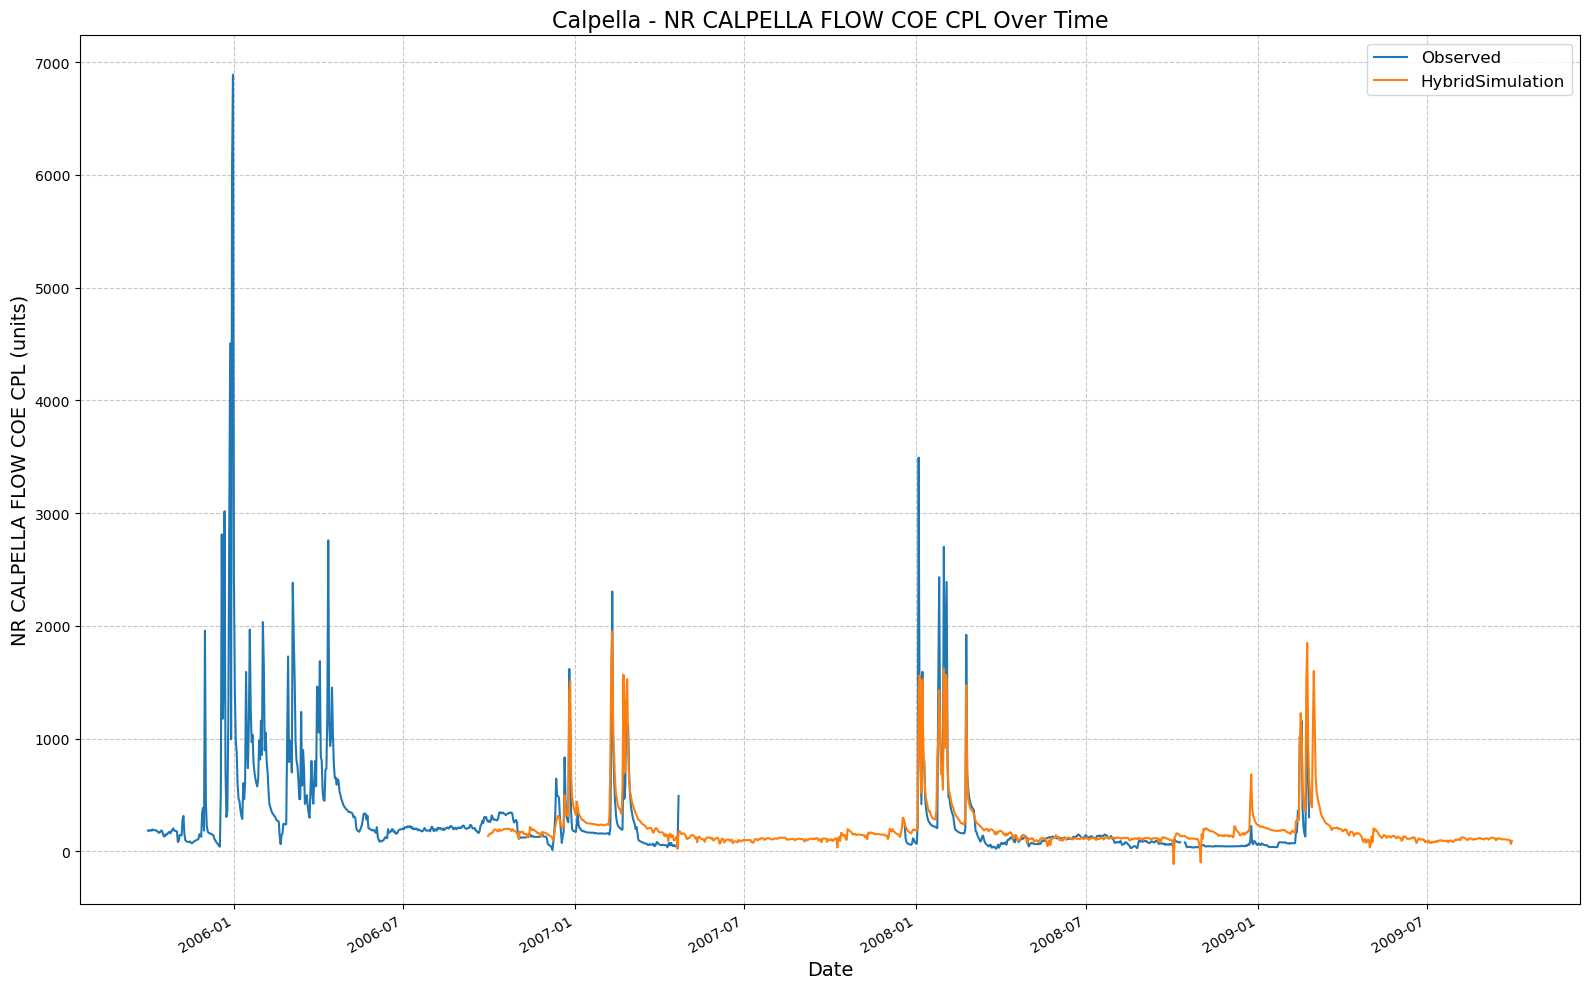

[INFO] CSV output saved at: /Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_2811_092750/results_output.csv


{'NSE': 0.7266940772533417,
 'MSE': 28632.5,
 'RMSE': 169.21140623492258,
 'KGE': 0.6555115225333409,
 'Alpha-NSE': 0.8404571526628346,
 'Beta-KGE': 1.275919795036316,
 'Beta-NSE': 0.16771909710321953,
 'Pearson-r': 0.8692840572922941,
 'FHV': -18.2094007730484,
 'FMS': -33.17978595887079,
 'FLV': -1138.3936185857103,
 'Peak-Timing': 1.0,
 'Peak-MAPE': 38.70718479156494}

In [5]:
lstmPhysics.results()